In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import max_tree
from skimage.morphology import area_opening
from skimage.morphology import intensity_opening
from skimage.morphology import diameter_opening
from skimage.morphology import attribute_opening
from skimage import io
from matplotlib.lines import Line2D
import networkx as nx

Helper functions (repeated from the workshop):

In [2]:
def plot_img(ax, image, title, plot_text, image_values):
    """Plot an image, overlaying image values or indices."""
    ax.imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=np.max(image))
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

    for x in np.arange(-0.5, image.shape[0], 1.0):
        ax.add_artist(Line2D((x, x), (-0.5, image.shape[0] - 0.5),
                             color='blue', linewidth=2))

    for y in np.arange(-0.5, image.shape[1], 1.0):
        ax.add_artist(Line2D((-0.5, image.shape[1]), (y, y),
                             color='blue', linewidth=2))

    if plot_text:
        for i, j in np.ndindex(*image_values.shape):
            ax.text(j, i, image_values[i, j], fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='red')
    return


def prune(G, node):
    """Transform a canonical max tree to a max tree."""
    value = G.nodes[node]['value']
    #res[node] = str(node)
    G.nodes[node]['label'] = str(node)
    preds = [p for p in G.predecessors(node)]
    for p in preds:
        if (G.nodes[p]['value'] == value):
            G.nodes[node]['label'] += ', %i' % p
            G.remove_node(p)
        else:
            prune(G, p)
    #G.nodes[node]['label'] = res[node]
    #return


def accumulate(G, node):
    """Transform a max tree to a component tree."""
    total = G.nodes[node]['label']
    parents = G.predecessors(node)
    for p in parents:
        total += ', ' + accumulate(G, p)
    #res[node] = total
    G.nodes[node]['label'] = total
    return total


def position_nodes_for_max_tree(G, root_x=4, delta_x=1.2):
    """Set the position of nodes of a max-tree.

    This function helps to visually distinguish between nodes at the same
    level of the hierarchy and nodes at different levels.
    """
    pos = {}
    for node in reversed(list(nx.topological_sort(G))):
        value = G.nodes[node]['value']
        if G.out_degree(node) == 0:
            # root
            pos[node] = (root_x, value)

        in_nodes = [y for y in G.predecessors(node)]

        # place the nodes at the same level
        level_nodes = [y for y in
                       filter(lambda x: G.nodes[x]['value'] == value, in_nodes)]
        nb_level_nodes = len(level_nodes) + 1

        c = nb_level_nodes // 2
        i = - c
        if (len(level_nodes) < 3):
            hy = 0
            m = 0
        else:
            hy = 0.25
            m = hy / (c - 1)

        for level_node in level_nodes:
            if(i == 0):
                i += 1
            if (len(level_nodes) < 3):
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x, value)
            else:
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x,
                                   value + m * (2 * np.abs(i) - c - 1))
            i += 1

        # place the nodes at different levels
        other_level_nodes = [y for y in
                             filter(lambda x: G.nodes[x]['value'] > value, in_nodes)]
        if (len(other_level_nodes) == 1):
            i = 0
        else:
            i = - len(other_level_nodes) // 2
        for other_level_node in other_level_nodes:
            if((len(other_level_nodes) % 2 == 0) and (i == 0)):
                i += 1
            pos[other_level_node] = (pos[node][0] + i * delta_x,
                                     G.nodes[other_level_node]['value'])
            i += 1

    return pos

def plot_tree(graph, positions, ax, *, title='',
              font_size=8, text_size=8):
    """Plot max and component trees."""
    
    labels = dict([y for y in filter(lambda x: x[1] is not None, list(graph.nodes(data='label')))])
           
    if len(labels) == 0:
        labels = None
        
    nx.draw_networkx(graph, pos=positions, ax=ax,
                     node_size=40, node_shape='s', node_color='white',
                     font_size=font_size, labels=labels)

    xlimit = ax.get_xlim()

    image_values = np.array([graph.nodes[node]['value'] for node in graph.nodes()], dtype = np.uint8)
    for v in range(image_values.min(), image_values.max() + 1):
        ax.hlines(v - 0.5, -3, 10, linestyles='dotted')
        ax.text(-3, v - 0.15, "val: %i" % v, fontsize=text_size)
    ax.hlines(v + 0.5, -3, 10, linestyles='dotted')
    ax.set_xlim(-3, 10)
    ax.set_title(title)
    ax.set_axis_off()
    
def plot_max_tree(P, S, image, ax, *, title='', cannonical = False):
    P_rav = P.ravel()
    max_tree = nx.DiGraph()
    max_tree.add_nodes_from(S)
    image_rav = image.ravel()
    for node in max_tree.nodes():
        max_tree.nodes[node]['value'] = image_rav[node]
    max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])
    
    if not cannonical:
        prune(max_tree, S[0])
    
    pos_mt = position_nodes_for_max_tree(max_tree)
    
    plot_tree(max_tree, pos_mt, ax = ax, title=title)
    
    ylim = ax.get_ylim()
    if ylim[0] < ylim[1]:
        ax.invert_yaxis()

from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Hide/Show Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

# Excercise A

For the first few excercises, we will be using a toy image and the associated max-tree. Here, we initialize the image, and then display it and its max-tree.

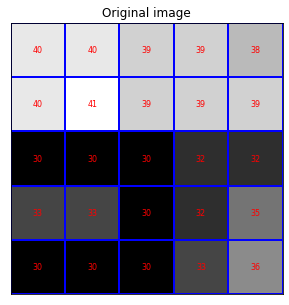

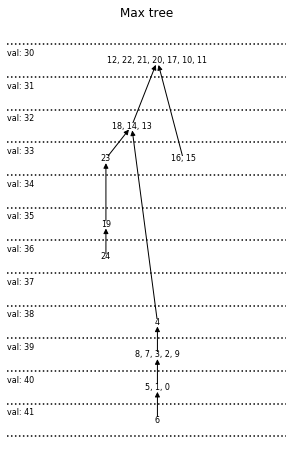

In [3]:
image = np.array([[40, 40, 39, 39, 38],
                  [40, 41, 39, 39, 39],
                  [30, 30, 30, 32, 32],
                  [33, 33, 30, 32, 35],
                  [30, 30, 30, 33, 36]], dtype=np.uint8)
P, S = max_tree(image)

P_rav = P.ravel()

fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

plot_img(ax, image - image.min(), 'Image Values', plot_text=True, image_values=image)
ax.set_title('Original image')

plt.show()

fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(5, 8))

plot_max_tree(P, S, image, ax, title = 'Max tree')


Task 1
----

For the toy image and max-tree displayed above, find the **area threshold** in the below code which would **remove all but 2 nodes** from the tree. This corresponds to a single-colour image with one slightly lighter "blob". The code below serves as a template to display the filtered tree and check the result.

**Bonus question**: Is it possible to find an _area threshold_ that would keep _less than 5 nodes_ from the above max-tree _located on at least 2 distinct branches?_ Why?


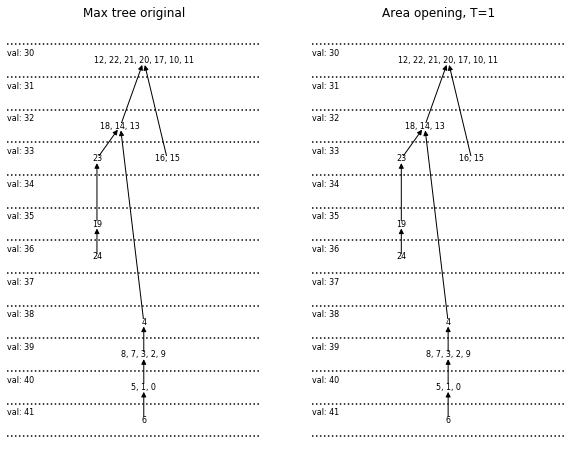

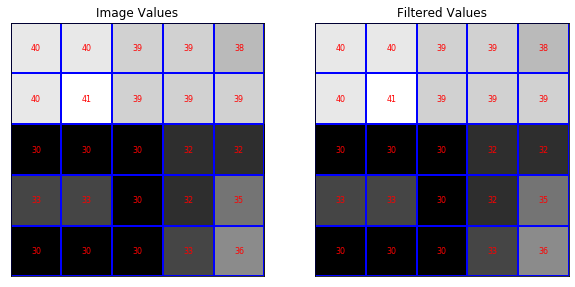

In [4]:
tr = 1
out_f, P_f = area_opening(image, tr, connectivity = 1, parent = P, tree_traverser = S)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 8))

plot_max_tree(P,   S, image, ax1, title = 'Max tree original')
plot_max_tree(P_f, S, out_f, ax2, title = 'Area opening, T={}'.format(tr))

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 10))

plot_img(ax1, image - image.min(), 'Image Values', plot_text=True, image_values=image)
plot_img(ax2, out_f - image.min(), 'Filtered Values', plot_text=True, image_values=out_f)

plt.show()

Task 2 (advanced)
----

Define the `intensity` attribute so that attribute filtering based on intensity range can be used through the general `attribute_opening` interface. The code below serves as a template to display and compare the trees filtered by `intensity_opening` and by `attribute_opening` relying on a user-defined function `my_intensity_range`. If `my_intensity_range` is implemented correctly, both output trees should look exactly the same.

(**Note:** Replace the dummy implementation of `my_intensity_range`, which is a placeholder assigning to each component an intensity range of `1000` (larger than possible for 8-bit images). This ensures that no nodes are removed when this dummy function is used for filtering in this example.)


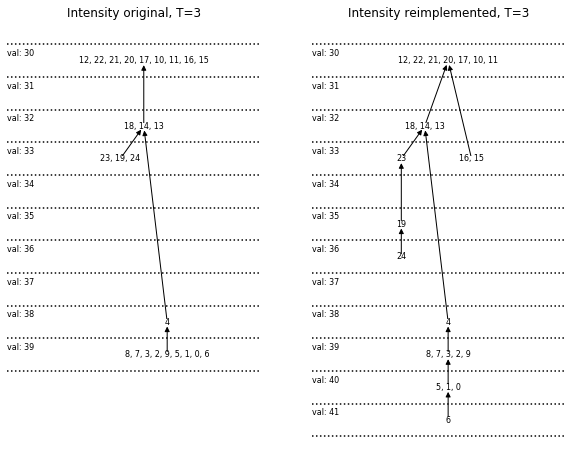

In [5]:
def my_intensity_range(parent, tree_traverser, image):
    # Change this function so that irange[q] contains
    # the intensity range for a node q, similarly to
    # how parent[q] holds the parent information of q
    
    irange = np.ones(len(parent.ravel()))
    irange *= 1000
    return irange

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 8))

tr_intensity = 3

out_i,  P_i  = intensity_opening(image, tr_intensity,
                                          connectivity = 1, parent = P, tree_traverser = S)

intensity_attribute = my_intensity_range(P,S, image)
out_mi, P_mi = attribute_opening(image, intensity_attribute, tr_intensity,
                                          connectivity = 1, parent = P, tree_traverser = S)

plot_max_tree(P_i,  S, out_i,  ax1, title = 'Intensity original, T={}'.format(tr_intensity))
plot_max_tree(P_mi, S, out_mi, ax2, title = 'Intensity reimplemented, T={}'.format(tr_intensity))

plt.show()

# Excercise B

For this excercise, we will be working with a (thumbnail) image of a leaf with holes. To begin with, we input the image as grayscale, construct the max-tree and display the image.

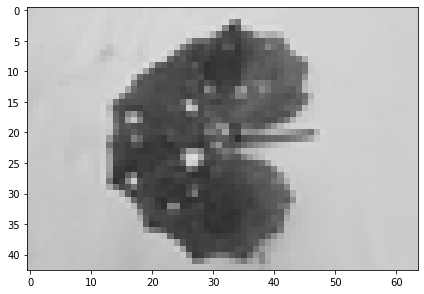

In [6]:
image_leaf = io.imread('holy_leaf_small.png', as_gray=True)

image_leaf = (image_leaf*255).astype(int)
P_leaf, S_leaf = max_tree(image_leaf)

fig, (ax) = plt.subplots(1, 1, sharey=False, figsize=(7, 7))

ax.imshow(image_leaf, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()

Task
------

**Analyse the leaf image!** Try and find the answer to the following question by applying different attribute filters to the max-tree:

- what is the **area** of the largest hole in the leaf?
- how can you filter out **all the holes except the largest** one?
- what is the **diameter** of the largest hole in the leaf?
- is there a difference between the largest **width** and **height** of the holes?

Use the code below as a template to examine the filtering results. You can _chain_ filtering operations if needed (nor _not_ if examining different effects!): this is done by using the `parent` returned from one filter in the next filter (while the `tree_traverser` does not change at all).

Possible functions needed: `area_opening`, `diameter_opening`, `attribute_opening` (and some helper functions from the workshop!)

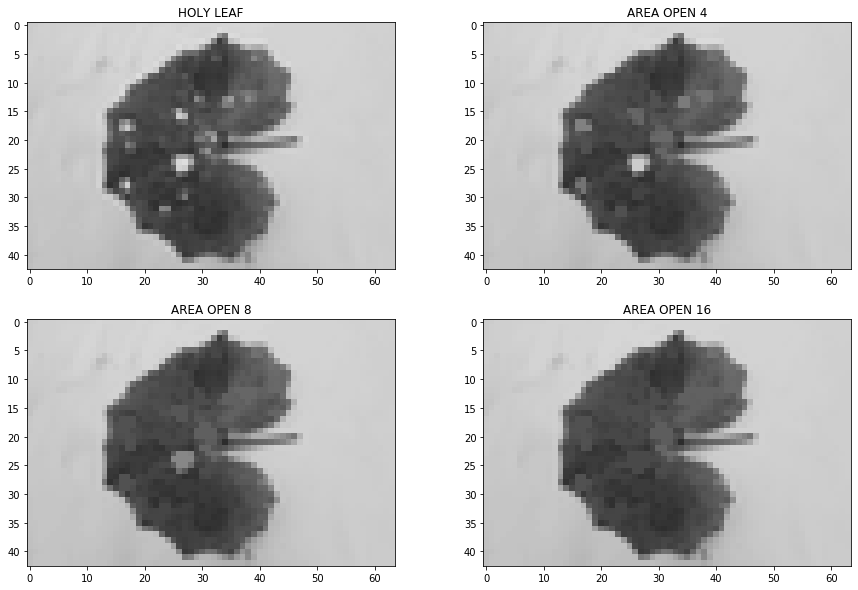

In [7]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 10))

axs[0][0].imshow(image_leaf, cmap = 'gray', vmin = 0, vmax = 255)
axs[0][0].set_title('HOLY LEAF')

leaf_f1, P_f1 = area_opening(image_leaf, 4, connectivity=1, parent=P_leaf, tree_traverser = S_leaf)
axs[0][1].imshow(leaf_f1, cmap = 'gray', vmin = 0, vmax = 255)
axs[0][1].set_title('AREA OPEN 4')

leaf_f2, P_f2 = area_opening(leaf_f1, 8, connectivity=1, parent=P_f1, tree_traverser = S_leaf)
axs[1][0].imshow(leaf_f2, cmap = 'gray', vmin = 0, vmax = 255)
axs[1][0].set_title('AREA OPEN 8')

leaf_f3, P_f3 = area_opening(leaf_f2, 16, connectivity=1, parent=P_f2, tree_traverser = S_leaf)
axs[1][1].imshow(leaf_f3, cmap = 'gray', vmin = 0, vmax = 255)
axs[1][1].set_title('AREA OPEN 16')

plt.show()